# Create supersites_geom.geojson geojson file with the caucus supersite borders
    
1. create supersites DataFrame from Judi's supersite precinct file
2. add ssname column to each precinct in pctgeo and save in pct_supersite.geojson
3. create pctgeo (precinct GeoDataFrame with precinct geometry from current pct_area_boulder.geojson file)
4. create supersitesgeo and add ssgeom column (supersite GeoDataFrame from supersites)
5. for each supersite create ssgeom around the precincts in the supersite
    - add ssgeom to each supersite in supersitesgeo
6. Save files in geojson format ready to be used directly in an online map
    - GeoJSON output files for Leaflet


- NOTE: need to update precinct to Supersite geojson every time a Supersite/precinct list is modified 
    - e.g. move precincts 814 and 823 from Frasier to Manhatten

- Started: January 7, 2024
- Update: January 8, 2024 - large revision - add ssname column to supersites
- Update: January 9, 2023 - version 0.1.0 add ssgeom to supersitesgeo
- Update: January 12, 2023 - version 0.2.0 add pctlist column to supersites dataframe

### Variables

- supersites    - DataFrame read from Judi's supersite file
- pctgeo        - GeoDataFrame read from pct_area_boulder.geojson
- sss_pcts_lists    - list of lists of all the precincts at a supersite

### Input Files

- Judi Bodinger's Caucus Supersite file with precinct column
    - supersiteDB/data/Draft Supersites-judi-20240106.xlsx
        - Supersite
        - Pct #'s
        ...
- 2022 precinct geometry file
    - data/pct_area_boulder.geojson

### Output Files
- supersites_geom.geojson
  - ssname
  - ssgeom - border around all precincts
- pct_supersite.geojson


##     ISSUES

#### Precinct format mismatch
- pct_area_boulder.geojson lists zero-filled precincts, e.g. 002, 003, 004
- Draft Supersites-judi-20240106.xlsx lists single-digit precincts, e.g. 2, 3, 4
    - notebook creates rows for both, 002 and 2, 003 and 3, 004 and 4
    - not critical failure but should be fixed. 
- WORKAROUND: drop extra rows 2, 3, 4
- FIXED: zfill precincts when reading in Judi's file


In [1]:
import pandas as pd
import geopandas as gpd
# import fiona
# import numpy as np

## 1. Create supersites - dataframe of supersites with list of precincts in a column  
- start with Judi's spreadsheet
### 2 add pctlist column to supersites and save in pct_supersite.geojson
- convert string of precinct numbers to list of precincts
- add pctlist to each supersite
- save in pct_supersite.geojson

In [2]:
# Convert string of precinct numbers to list of precincts

def pctstr_to_list(ss) :

    # transform each string in the list to a list of precinct numbers
    pctlist = ss["Pct #'s"].str.rstrip(',').str.split(',')

    # add leading zeros to single-digit precincts
    pctlist = [ [p.zfill(3) for p in pl] for pl in pctlist]
    
    return pctlist   


In [3]:
# Read current supersite list
supersites = pd.read_excel('data/Draft Supersites-judi-20240106.xlsx', sheet_name='Draft 1-6', skiprows=3)

# add pctlist column to supersites datafram
supersites = supersites.assign(pctlist = pctstr_to_list)

supersites.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Supersite               20 non-null     object 
 1   Region                  20 non-null     object 
 2   # of Reg Dems           20 non-null     int64  
 3   Forecast of  Attendees  20 non-null     float64
 4   # of Pct's              20 non-null     int64  
 5   Pct #'s                 20 non-null     object 
 6   # of Chairs             20 non-null     int64  
 7   Chair Name              20 non-null     object 
 8   Chair2 Name             13 non-null     object 
 9   Chair3 Name             8 non-null      object 
 10  chair 4 Name            2 non-null      object 
 11  Chair 5 Name            1 non-null      object 
 12  pctlist                 20 non-null     object 
dtypes: float64(1), int64(3), object(9)
memory usage: 2.2+ KB


In [4]:
# check pctlist 
# - list of precincts for each supersites
# - each precinct is 3-digits, e.g. 810 or 002
supersites['pctlist']

0     [810, 817, 818, 820, 821, 828, 829, 831, 832, ...
1                   [822, 823, 824, 825, 826, 827, 910]
2     [803, 804, 805, 806, 807, 808, 811, 812, 813, ...
3                                                 [913]
4     [004, 500, 501, 834, 835, 836, 837, 838, 839, ...
5     [830, 843, 844, 845, 846, 847, 850, 851, 852, ...
6         [400, 401, 402, 403, 404, 405, 406, 407, 408]
7     [503, 504, 505, 506, 507, 508, 509, 510, 800, ...
8     [300, 301, 302, 303, 304, 305, 306, 307, 308, ...
9     [606, 607, 608, 609, 610, 611, 614, 615, 616, ...
10             [600, 601, 602, 603, 604, 605, 612, 613]
11    [626, 627, 628, 629, 643, 644, 645, 646, 617, ...
12    [002, 618, 619, 620, 621, 622, 623, 633, 634, ...
13    [200, 201, 202, 203, 204, 205, 206, 207, 208, ...
14                                                [914]
15                                                [909]
16                            [700, 701, 702, 915, 916]
17                       [901, 902, 903, 904, 90

## 3 Create pctgeo - supersite pct Boundary Files


In [9]:
# 2. Create GeoDataframe from file with individual precinct boundaries
# data/pct_area_boulder.geojson
pctgeo = gpd.read_file('data/pct_area_boulder.geojson', driver='GEOJSON')

# set pctgeo index to Pct
pctgeo = pctgeo.set_index('Pct', drop=False)

pctgeo.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 16.1+ KB


In [11]:
pctgeo.head()

,Pct,Precinct,AreaShort,CD,SD,HD,geometry
Pct,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1..."
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9..."
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9..."
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9..."


### Check precinct data in  geodataframe
- Number of precincts = 193
- Number of Areas = 27
- Review Area_Short column
- Check # of precincts in each Area

In [12]:
pctgeo['Pct'].nunique() # 193

193

In [13]:
pctgeo.AreaShort.nunique() # 27

27

In [14]:
pctgeo.value_counts('AreaShort').sort_index()

AreaShort
BO-01     7
BO-02     5
BO-03     6
BO-04    10
BO-05     5
BO-07     6
BO-08     5
BO-09     5
BO-10     7
BO-11     6
ER-01     9
GN-01     7
LF-01     9
LF-02    11
LM-01     7
LM-02     7
LM-03     7
LM-04     9
LM-05     8
LM-06     8
LM-07    10
LV-01     7
LV-02     6
MT-01     6
MT-02     6
MT-03     6
SU-01     8
Name: count, dtype: int64

In [15]:
pctgeo.head()

,Pct,Precinct,AreaShort,CD,SD,HD,geometry
Pct,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1..."
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9..."
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9..."
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9..."


### add supersite name to pctgeo

In [16]:
pctgeo['supersite'] = ''
pctgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 17.6+ KB


In [108]:
# Run on all supersites

# loop through all supersites
for ss in supersites.index:

    # get pctlist in first supersite
    # ss = 0
    pctlist = supersites['pctlist'][ss]
    # print(pctlist, '\n')  # list of pcts in first supersite

    # get supersite name
    ssname = supersites.loc[ss,'Supersite'] 

    # loop through each pct in pctlist

    for p in pctlist:
        
        # print(p, ssname,'\n')  # Boulder HS

        # add supersite name to pctgeo
        pctgeo.loc[p, 'supersite'] = ssname
        # print(pctgeo.loc[p, 'supersite'], ssname)
        # print(pctgeo.loc[p, :], '\n')  #  dataframe row



In [109]:
pctgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 196 entries, 002 to 3
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  196 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 17.9+ KB


In [110]:
pctgeo

,Pct,Precinct,AreaShort,CD,SD,HD,geometry,supersite
Pct,,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1...",
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9...",
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9...",
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9...",Eldorado K8
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9...",Eldorado K8
...,...,...,...,...,...,...,...,...
915,915,2154907915,MT-03,2,15,49,"POLYGON ((-105.24898 40.21229, -105.24935 40.2...",Lyons Middle Senior
916,916,2154907916,MT-03,2,15,49,"POLYGON ((-105.19594 40.26146, -105.19971 40.2...",Lyons Middle Senior
4,NaN,NaN,NaN,NaN,NaN,NaN,None,Manhattan MS


In [111]:
# drop single digit rows that are duplicates of 002, 003 and 004
pctgeo = pctgeo.dropna(subset=['Pct'])
pctgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  193 non-null    object  
dtypes: geometry(1), object(7)
memory usage: 17.6+ KB


In [112]:
pctgeo

,Pct,Precinct,AreaShort,CD,SD,HD,geometry,supersite
Pct,,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1...",
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9...",
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9...",
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9...",Eldorado K8
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9...",Eldorado K8
...,...,...,...,...,...,...,...,...
912,912,2154907912,MT-02,2,15,49,"POLYGON ((-105.28214 40.10589, -105.28211 40.1...",Centennial MS
913,913,2154907913,MT-02,2,15,49,"POLYGON ((-105.32867 40.10536, -105.32858 40.1...",Jamestown School
914,914,2154907914,MT-03,2,15,49,"POLYGON ((-105.33835 40.25280, -105.33828 40.2...",Allenspark Fire Station


In [113]:

pctgeo.to_file('data/pct_supersite.geojson', driver='GeoJSON', index=False)


### 4 Create Supersite GeoDataFrame and add geometry column 

- create ssgdf - supersite GeoDataFrame
- add ssgeom column to ssgdf

In [117]:
# create an empty geodataframe to collect the supersite precints geometry
ssgdfcols = ['Supersite', 'sgeom']
ssgdf = gpd.GeoDataFrame(columns=ssgdfcols, geometry='sgeom')

ssgdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Supersite  0 non-null      object  
 1   sgeom      0 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 124.0+ bytes


### 5 Calculate supersite boundaries
- for each supersite
    - calculate ssgeom boundaries 
    - add ssgeom value to supersite row

In [ ]:
# Create an outline of all precincts in each ss
    # for each supersite
        # create a gdf with each precinct's geometry in a row
        # dissolve the gdf into a single outline border

# get pctlist in first supersite
# ss = 0
# ssname = supersites['Supersite'][ss]
# pctlist = supersites['pctlist'][ss]
# print(ssname, pctlist, '\n')  # list of pcts in first supersite

# create an empty geodataframe to collect the supersite precints geometry
ssgdfcols = ['Pct', 'Supersite', 'pgeom']
ssgdf = gpd.GeoDataFrame(columns=ssgdfcols, geometry='pgeom')
# print(ssgdf.info())

#  add a row for each precinct in pctlist

for p in pctlist:
    
    # print(p, ssname,'\n')  # Boulder HS

    # add precinct geometry to ssgdf
    pgeom = pctgeo.loc[p,'geometry']
    # print(pgeom)
    ssgdf.loc[p, 'pgeom'] = pgeom
# print(ssgdf)

# calculate supersite border geometry

ssgeom = ssgdf.dissolve()





<Axes: >

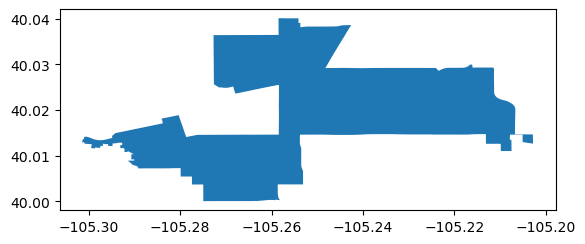

In [ ]:

ssgeom.plot()

# add supersite geometry to supersitesgdf

### 3 SAVE supersite_pct_geom.geojson file

### REFERENCE CODE from pct_area_geom.ipynb  Create Area Boundaries
- use .dissolve() to aggregate precincts into Areas and return Area boundary geometry

In [ ]:
area_groups = pctgeo.groupby('AreaShort')

In [ ]:
area_groups.groups

In [ ]:
# type(area_groups.get_group('BO-01'))
area_groups.get_group('BO-01')

In [ ]:
# Create boundary for each Area from outline of precincts in Area
for name, group in area_groups:
    area_gdf = pd.concat([area_gdf, group.dissolve()], ignore_index=True)   

In [ ]:
area_gdf.info()

In [ ]:
area_gdf

In [ ]:
# Delete duplicate 1st row
area_gdf.drop(0, inplace=True)

In [ ]:
area_gdf = area_gdf[['AreaShort', 'geometry']]
area_gdf

In [ ]:
area_gdf.plot()

In [ ]:
area_gdf.to_file('../geo/geojson/areas.geojson', driver='GeoJSON')

### test areas.geojson

In [ ]:
area_test = gpd.read_file('../geo/geojson/areas.geojson', driver='GeoJSON')
area_test.info()

In [ ]:
area_test[area_test.AreaShort == 'BO-09'].plot()

## Transform data in dataframes

## Save transformed data in map format files